In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os

import keras

import librosa
import librosa.display

# Get data

In [2]:
path = "C:\\Users\\daniel.martinezcarre\\Desktop\\Repositorios\\ia_repositorio\\sistemas_de_aprendizaxe_automatico\\audio-mnist\\recordings"

def get_data(data_dir):
    data = [] 
    for audio in os.listdir(data_dir):
        try:
            class_num = audio[0]
            ruta = os.path.join(data_dir, audio)
            samples, sample_rate = librosa.load(ruta, sr=None, mono=False)
            data.append([samples, sample_rate, class_num])
        except Exception as e:
            print(e)
    return data

lista_audios = get_data(path)


In [3]:
print(f"Shape: {lista_audios[0][0].shape} Sample Rate: {lista_audios[0][1]} Type: {type(lista_audios[0][0])}  Numero: {lista_audios[0][2]}")

Shape: (2384,) Sample Rate: 8000 Type: <class 'numpy.ndarray'>  Numero: 0


In [4]:
from IPython.display import Audio
Audio(lista_audios[34][0], rate=lista_audios[34][1])

Ya están en mono

In [5]:
# Sample rate adaptado
sr = 22050
# Tamaño 1s
max_ms = 1000
# Desplazamiento
shift_limit = 0.1 # % a desplazar
# Relación señal/ruido
SNR = 50

# Spectogramas
specto_data = []
# Números
numeros = []

for audio in lista_audios:
    samples = audio[0]
    sample_rate = audio[1]
    numero = audio[2]

    # Tranformar a mono
    samples_mono = librosa.to_mono(samples)

    # Adaptar el Sample Rate apara voz
    sample_resamp = librosa.resample(samples_mono, orig_sr=sample_rate, target_sr=sr)
    
    # Tamaño a 4s
    sig_len = sample_resamp.shape[0]
    max_len = (sr*max_ms)//1000

    if sig_len >= max_len:
        samples_trunc = sample_resamp[:max_len]
    else:
        z = np.zeros(max_len - sig_len, dtype=sample_resamp.dtype)
        samples_trunc = np.concatenate((sample_resamp, z), axis=0)

    # Se añade desplazamientos 
    sig_len = samples_trunc.shape[0]
    shift_len = int(shift_limit * sig_len)
    samples_shift = np.roll(samples_trunc, shift_len)

    # RUIDO
    RMS_s = math.sqrt(np.mean(samples_shift**2))    # RMS señal
    RMS_n = math.sqrt(RMS_s**2/(pow(10, SNR/10)))   # RMS deseado ruido
    noise = np.random.normal(0, RMS_n, samples_shift.shape[0]) # normal media 0 y desviación std
    samples_noise = samples_shift + noise

    # Pasar a spectograma
    sgram = librosa.stft(samples_noise, n_fft=1024, hop_length=None)
    sgram, _ = librosa.magphase(sgram)

    # Frecuencia a escala de mel
    sgram = librosa.feature.melspectrogram(S=sgram, sr=sr, n_mels=64)

    # Amplitud
    sgram = librosa.amplitude_to_db(sgram, ref=np.min)

    specto_data.append(sgram)   
    numeros.append(numero)

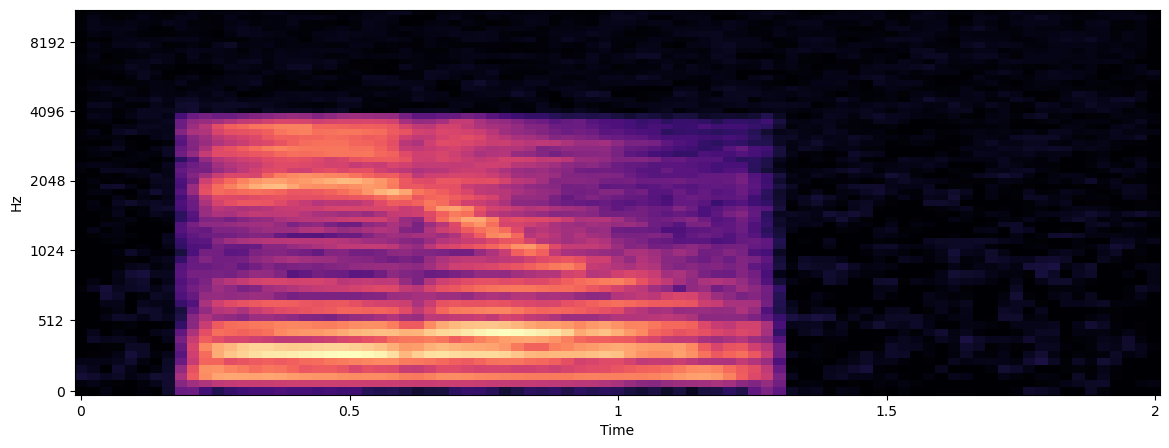

In [6]:
plt.figure(figsize=(14,5))
librosa.display.specshow(specto_data[6], sr=sr, x_axis="time", y_axis="mel")

# Creación de modelo

## Preparación de datos

In [7]:
X = specto_data # Espectogramas de cada audio
y = numeros # Números que corresponde cada audio

### Barajar pares

In [8]:
pares = list(zip(X,y))

random.shuffle(pares)

### Sacar valores barajados

In [9]:
X_barajado = []
y_barajado = []
for par in pares:
    espectrograma_audio, numero_y = par
    X_barajado.append(espectrograma_audio)
    y_barajado.append(int(numero_y))

### Conversión de las listas a matrices

In [10]:
X_barajado = np.array(X_barajado)
y_barajado = np.array(y_barajado)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_barajado = le.fit_transform(y_barajado)

### División de datos para cada conjunto (train, test, val)

In [11]:
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(X_barajado, y_barajado, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [12]:
# int_converter = lambda y: int(y)
# y_train = int_converter(y_train)
# y_test = int_converter(y_test)
# y_val = int_converter(y_val)

In [13]:
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test =np.array(X_test) / 255

In [14]:
print(f"X_train: {len(X_train)}, X_test: {len(X_test)}, X_val: {len(X_val)}")

X_train: 1920, X_test: 600, X_val: 480


## Creación de red neuronal

In [15]:
X_train.shape

(1920, 64, 87)

In [19]:
from tensorflow.keras import layers, models

num_classes = 10

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 87, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes,  activation='softmax'))

model.summary()

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", 
              metrics=["accuracy"])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 85, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 17920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     1,146,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,168,170 (4.46 MB)

 Trainable params: 1,168,170 (4.46 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
y_train

array([9, 8, 7, ..., 5, 0, 1], dtype=int64)

In [21]:
epochs = 10000

early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs,
                    callbacks= [early_stopping],
                    validation_data=(X_val, y_val))

Epoch 1/10000


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1079 - loss: 2.2996 - val_accuracy: 0.2292 - val_loss: 2.1940
Epoch 2/10000
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2540 - loss: 2.0998 - val_accuracy: 0.3979 - val_loss: 1.6039
Epoch 3/10000
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5626 - loss: 1.2893 - val_accuracy: 0.7083 - val_loss: 0.8743
Epoch 4/10000
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7595 - loss: 0.7688 - val_accuracy: 0.7812 - val_loss: 0.6546
Epoch 5/10000
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8177 - loss: 0.5800 - val_accuracy: 0.8396 - val_loss: 0.5052
Epoch 6/10000
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8414 - loss: 0.4772 - val_accuracy: 0.8646 - val_loss: 0.4357
Epoch 7/10000
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8917 - loss: 0.3483 - val_accuracy: 0.9042 - val_loss: 0.3245
Epoch 8/10000
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9217 - loss: 0.2416 - val_accuracy: 

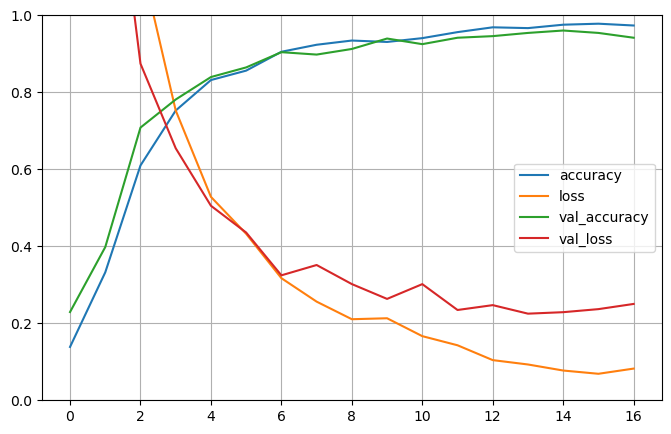

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [23]:
model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9581 - loss: 0.1524


[0.14587673544883728, 0.9583333134651184]

# Predicciones

In [36]:
X_nuevas = X_test[:10]
y_nuevas_pred = model.predict(X_nuevas)
y_nuevas_pred.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


array([[0.  , 0.  , 0.01, 0.82, 0.  , 0.  , 0.17, 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.97, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.54, 0.  , 0.  , 0.16, 0.  , 0.31, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.19, 0.78, 0.  , 0.  ],
       [0.2 , 0.  , 0.7 , 0.09, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [37]:
y_pred = np.argmax(y_nuevas_pred, axis=1)
y_pred

array([3, 1, 7, 4, 5, 3, 6, 7, 2, 5], dtype=int64)

In [38]:
y_test[:10]

array([3, 1, 7, 4, 5, 8, 6, 7, 0, 5], dtype=int64)